## Reproduce the Code previously used to improve in vivo binding

Some of the main requirements to do this are:
* The modified Perl code used to incorporate in vivo information
* The helper scripts used for counting and data conversion
* The kmer counts previously generated:
 - Counts in human genome
 - count in Dnase data
 - frequency difference of that count
* Then we can directly generate the motifs and test how they are performing


With the machine learning angle to the project established, the next stage is to get this working. Improve on it by using a better scoring function, and also do a bit of comparisons. 

Some action points related to this chapter:
* Transform debruijn with dn-hg
* A baclground noise correction
    * Re-rank with k-mer frequency count difference (hg-dn, considered as noise)
    * Jiangs approach



### Import the necessary modules

In [1]:
import os
import glob

%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
pd.set_option('display.max_colwidth', -1)

BASE_DIR = "/home/kipkurui/Project/PBM_DNase"

/home/kipkurui/anaconda2/envs/dream_challenge/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
pbm_chip = []
pbmchip2name = {}
with open('/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/Data/Pbm_Chip_details.txt') as pbmnchip:
    for line in pbmnchip:
        if line.startswith('Tf_id'):
            continue
        else:
            pbm_chip.append(line.split()[0])
            pbmchip2name[line.split()[0]] = line.split()[1]
            
name2pbmchip = {v: k for k, v in pbmchip2name.items()}


In [4]:
sticky_tfs = pd.read_table("/home/kipkurui/Project/Others_work/Bayesian_PBM_Analysis/Bayesian_PBM_Analysis/anova_example/input/names.txt", header=None)
tf_list = []
for tf in sticky_tfs[0]:
    chip_list = glob.glob("/home/kipkurui/Project/MARS/Data/ChIP-seq/Derived/Posneg/%s/*" % tf.capitalize())
    if len(chip_list) > 0:
        tf_list.append(tf)

In [5]:
tf_list

['Foxa2',
 'Gata3',
 'Max',
 'Tcf3',
 'Tcf7l2',
 'Irf3',
 'Irf4',
 'Hnf4a',
 'Nr2f2',
 'Rxra',
 'Egr1',
 'Sp4']

### Download the DREAM data for assessment later

In [ ]:
# from dreamtools import D5C2
# s = D5C2()
# s.download_all_data()

With all the data downloaded, I should be able to train and predict on the given data. Just need to master how to do that easily. Now I need to get my scripts working. 

### Training a model using DNase data

Here I need to create a function that does the whole training in a sinlge stroke, just by providing the TF name and should be able to get the other information and run the analysis. This way, I should lower the turn around and tweaking. 



This is a complete reproduction of the whoel process form start to finish. 

In [ ]:
# !perl counts_seed_and_wobble_twoaray.pl Max_3863.1_v1_deBruijn.txt Max_3863.1_v2_deBruijn.txt 8 patterns_8of10.txt patterns_4x44k_all_8mer.txt combinedcounts.txt Max_3863.1

# !perl rerank.pl Max_3863.1_v2_deBruijn.txt Max_3863.1_8mers_pwm_combined.txt Max_3863.1_v2_reranked.txt
# !perl rerank.pl Max_3863.1_v1_deBruijn.txt Max_3863.1_8mers_pwm_combined.txt Max_3863.1_v1_reranked.txt

# !perl seed_and_wobble_twoarray.pl Max_3863.1_v1_reranked.txt Max_3863.1_v2_reranked.txt 8 patterns_8of10.txt patterns_4x44k_all_8mer.txt Max_3863-freqreranked

# !perl seed_and_wobble_twoarray.pl Max_3863.1_v1_deBruijn.txt Max_3863.1_v2_deBruijn.txt 8 patterns_8of10.txt patterns_4x44k_all_8mer.txt Max_3863-normal
# !python wobble2meme.py Max_3863-normal_8mers_pwm_combined.txt Max_3863-normal.uniprobe Max_3863-normal.meme Max-normal

### Implementing k-mer scoring and re-ranking

The purpose of this is to get re-produce my previous implemenation of k-mer scoring in order to understand what I had previously done. The intent is to also have a look at the grounding of my approach and determine, given my current understanding, if there is a better way about it. The building bocks of this implementation are:
* Creat a dictionary of kmer-scores
* Extract k-mers from given sequence
* K-mer scoring function
* Function to combine and normalize the scores

The next step is to create my own pipeline for assessing teh quality of the motifs against my database of motifs as quickly as possible. This is to ensure that I can esily iterate over the various possible solutions and reach the best option fast. 

## Put all the functions here, and ensure we understand what each does in order to remove unnecessary ones

In [340]:
revcompl = lambda x: ''.join([{'A':'T','C':'G','G':'C','T':'A'}[B] for B in x][::-1])

def score_kmer(kmer,kmerdict,revcompl):
    score=0
    if kmer in kmerdict:
        score=float(kmerdict[kmer])
    else:
        kmer2=revcompl(kmer)
        score=float(kmerdict[kmer2])
    return score

def energy_score_kmer(seq,kmerdict,revcompl):
    k_mers=find_kmers(seq,8)
    tot_score = 0
    for kmer in k_mers:
        if kmer in kmerdict:
            score=float(kmerdict[kmer])
        else:
            kmer2=revcompl(kmer)
            score=float(kmerdict[kmer2])
        tot_score+=score
    return tot_score

def find_kmers(string, kmer_size):
    kmers = []
    for i in range(0, len(string)-kmer_size+1):
        kmers.append(string[i:i+kmer_size])
    return kmers

def getKey(item):
    return item[1]

def get_kmer_dict(kmerscore, kmer_name):
    scoredict={}
    with open(kmerscore) as kmers:
        for line in kmers:
            ke,rem, val=line.split()
            scoredict[ke]=val
    return scoredict, kmer_name

def max_score_kmer(kmerdict, seq):
    k_mers = find_kmers(seq, 8)
    tot_score = []
    for kmer in k_mers:
        if kmer in kmerdict:
            score = float(kmerdict[kmer])
        else:
            score = 0.0
            #kmer2 = revcompl(kmer)
            #score = float(kmerdict[kmer2])
        tot_score.append(score)
    return max(tot_score)


def max_score_kmer_pos(kmerdict, seq):
    k_mers = find_kmers(seq, 8)
    tot_score = []
    for kmer in k_mers:
        if kmer in kmerdict:
            score = float(kmerdict[kmer])
        else:
            score = 0.0
            #kmer2 = revcompl(kmer)
            #score = float(kmerdict[kmer2])
        tot_score.append(score)
    max_pos = tot_score.index(max(tot_score))
    
    return sum(tot_score[max_pos-4:max_pos+4]), max_pos-4

In [ ]:
kmerscore = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/Egr1/Egr1_2580.2_deBruijn_8mers_combined.txt"

In [ ]:
#test = pd.read_table(kmerscore, index_col="8-mer")
test = pd.read_table(kmerscore, index_col="8-mer", usecols=["8-mer", "E-score"])

test2 = pd.read_table(kmerscore, index_col="8-mer.1", usecols=["8-mer.1", "E-score"])
test2.index.name = "8-mer"

combined = test.append(test2)
combined_dict = combined.to_dict()["E-score"]
#scoredict  = kmer_dict = test.to_dict()["E-score"]

In [ ]:
combined[combined["E-score"] >0.35]

In [ ]:
combined.sort_values(by="E-score", ascending=False)

### The re-ranking code

In [323]:
def run_kmersocre(tf, scoring_function, k_mer_list, chip_seq_list, results_folder_path):
    """
    Input:
        - tf name
        - scoring function 
        - A list of k-mer containing files to work with
    
    """
    import random
    if len(chip_seq_list) > 10:
        random.seed(10)
        chip_seq_list = random.sample(chip_seq_list, 10)

    score_option = scoring_function
    summary_output_file = "%s/%s.%s" % (results_folder_path, tf.lower(), score_extensions[scoring_function])
    raw_output_file = "%s/%s_raw.%s" % (results_folder_path, tf.lower(), score_extensions[scoring_function])
    pr = "%s\t%s\t%s\t%s\t%s\n" % ("Motif", "AUC", "MNCP", "Pearson", "Spearman")

    file_header = "%s\t%s\t%s\t%s\t%s\t%s\n" % ("Cell_lab", "Motif", "AUC", "MNCP", "Pearson", "Spearman")

    with open(summary_output_file, "w") as write_summary:
        with open(raw_output_file, "w") as write_raw:
            write_summary.write(pr)
            write_raw.write(file_header)

    #tf_names = get_tf_names(user_motif)
    
    for mot_name in k_mer_list:
        kmer_name = mot_name.split("/")[-1]
        user_motif_details = get_kmer_dict(mot_name, kmer_name)
        run_assess(score_option, summary_output_file, raw_output_file, user_motif_details, chip_seq_list)
        
def get_kmer_dict(kmerscore, kmer_name):
    """
    Try and make this generalized by checking if the first line has header or not. 
    
    Also, check the number of columns and determine which one contains the E-scores
    """

    test = pd.read_table(kmerscore, index_col="8-mer", usecols=["8-mer", "E-score"])

    scoredict  = test.to_dict()["E-score"]
    # with open(kmerscore) as kmers:
    #     print kmerscore
    #     for line in kmers:
    #         ke, rems, val = line.split("\t")
    #
    #         scoredict[ke] = val
    return scoredict, kmer_name

def get_unique(tf):
    import glob
    lests = glob.glob("/home/kipkurui/Project/MARS/Data/PBM/%s/*" % tf.capitalize())
    new = []
    for i in lests:
        main = i.split("_v")[0]
        if main in new:
            continue
        else:
            new.append(main)
    return new

def mkdir_p(path):
    import os
    import errno

    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
def transform_deBruijn(tf, kmerscore):
    """
    Given kmer frequency counts, use the information to tranform the deBruijn 
    intensity scores in a way that would reflect in vivo binding behaviour. 
    TODO: Test this using a different scoring function
    """
    scoredict = get_kmer_dict(kmerscore,"test")
    out_dir = "/home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked/%s" % tf.capitalize()
    mkdir_p(out_dir)
    for probe in get_unique(tf):
        for i in range(1,3):
            debru = pd.read_table("%s_v%i_deBruijn.txt" % (probe,i), header=None)
            scored = debru[1].apply(lambda seq: energy_score_kmer(seq[:36],scoredict,revcompl))
            normalized = scored/scored.max()
            test = pd.DataFrame()
            test = test.append(debru[0]*normalized, ignore_index=True)
            finall = test.append(debru[1]).T
            finall.sort_values(by=0, ascending=False, inplace=True)
            probe_n =probe.split("/")[-1]
            finall.to_csv("%s/%s_v%i_reranked_Hg_dn.txt" % (out_dir, probe_n,i), sep="\t", index=None, index_label=None, header=None)

In [3]:
import errno
print errno.EEXIST

17


In [325]:
transform_deBruijn("Tcf3", "/home/kipkurui/Project/PBM_DNase/Data/Dn_hg_max_normalized.txt")

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [7]:
scripts_path = "/home/kipkurui/Project/PBM_DNase/Scripts"
!cd {scripts_path}
def combine_meme(tf, path="%s/Results/PBM_Reranked" % BASE_DIR):
    meme_out = "%s/%s/%s.meme" % (path,tf.capitalize(), tf.capitalize())
    if os.path.isfile(meme_out):
        os.remove(meme_out)
    meme_motifs = glob.glob("%s/%s/*meme" % (path,tf.capitalize()))
    
    mot = meme_motifs[0]
    !head -9 {mot} >{meme_out}
    for mot in meme_motifs:
        tots = !wc -l {mot}
        !tail -{int(tots[0].split()[0]) -8} {mot} >>{meme_out}

def run_SnW(tf):
    """
    Give a TF name, can I run the whole proces in one go?
    """
    out_dir = "/home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked/%s" % tf.capitalize()
    res_dir = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/%s" % tf.capitalize()
    mkdir_p(res_dir)
    for probe in get_unique(tf):
        probe_n =probe.split("/")[-1]
        v1 = "%s/%s_v%i_reranked_Hg_dn.txt" % (out_dir, probe_n,1)
        v2 = "%s/%s_v%i_reranked_Hg_dn.txt" % (out_dir, probe_n,2)
        !perl {scripts_path}/seed_and_wobble_twoarray.pl {v1} {v2} 8 patterns_8of10.txt patterns_4x44k_all_8mer.txt {res_dir}/{probe_n}_reranked
        !python {scripts_path}/wobble2meme.py {res_dir}/{probe_n}_reranked_8mers_pwm_combined.txt {res_dir}/{probe_n}_reranked.uniprobe {res_dir}/{probe_n}_reranked.meme {probe_n}_reranked
    combine_meme(tf)
    run_assess(tf)

def run_SnW_normal(tf):
    """
    Give a TF name, can I run the whole proces in one go?
    """
    out_dir = "/home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked/%s" % tf.capitalize()
    res_dir = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/%s" % tf.capitalize()
    mkdir_p(res_dir)
    for probe in get_unique(tf):
        probe_n =probe.split("/")[-1]
        v1 = "%s_v%i_deBruijn.txt" % (probe,1)
        v2 = "%s_v%i_deBruijn.txt" % (probe,2)
        !perl seed_and_wobble_twoarray.pl {v1} {v2} 8 patterns_8of10.txt patterns_4x44k_all_8mer.txt {res_dir}/{probe_n}_deBruijn
        !python wobble2meme.py {res_dir}/{probe_n}_deBruijn_8mers_pwm_combined.txt {res_dir}/{probe_n}_deBruijn.uniprobe {res_dir}/{probe_n}_deBruijn.meme {probe_n}_deBruijn
    combine_meme(tf)
    run_assess(tf)
    
def run_SnW_counts(tf, scalled):
    """
    Give a TF name, run the counts SnW code to rerank the duBruijn file
    """
    out_dir = "/home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked/%s" % tf.capitalize()
    res_dir = "/home/kipkurui/Project/PBM_DNase/Results/PBM_PWM/%s" % tf.capitalize()
    mkdir_p(res_dir)
    for probe in get_unique(tf):
        print probe
        probe_n =probe.split("/")[-1]
        v1 = "%s_v%i_deBruijn.txt" % (probe,1)
        v2 = "%s_v%i_deBruijn.txt" % (probe,2)
        !perl counts_seed_and_wobble_twoarray.pl {v1} {v2} 8 patterns_8of10.txt patterns_4x44k_all_8mer.txt {scalled} {res_dir}/{probe_n}_Counts
        #!python wobble2meme.py {res_dir}/{probe_n}_deBruijn_8mers_pwm_combined.txt {res_dir}/{probe_n}_deBruijn.uniprobe {res_dir}/{probe_n}_deBruijn.meme {probe_n}_deBruijn
    #combine_meme(tf)
    #run_assess(tf)
    
def run_rerank(tf):
    """
    Give a TF name, run the counts SnW code to rerank the duBruijn file
    """
    out_dir = "/home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked/%s" % tf.capitalize()
    res_dir = "%s/Results/PBM_PWM/%s" % (BASE_DIR,tf.capitalize())
    mkdir_p(res_dir)
    for probe in get_unique(tf):
        print probe
        probe_n =probe.split("/")[-1]
        v1 = "%s_v%i_deBruijn.txt" % (probe,1)
        v2 = "%s_v%i_deBruijn.txt" % (probe,2)
        
        #!perl {scripts_path}/rerank.pl {v1} {res_dir}/{probe_n}_Counts_8mers_pwm_combined.txt {res_dir}/{probe_n}_v1_reranked.txt
        #!perl {scripts_path}/rerank.pl {v2} {res_dir}/{probe_n}_Counts_8mers_pwm_combined.txt {res_dir}/{probe_n}_v2_reranked.txt
        
        !perl {scripts_path}/seed_and_wobble_twoarray.pl {v1} {v2} 8 patterns_8of10.txt patterns_4x44k_all_8mer.txt {probe_n}
        
        #!python {scripts_path}/wobble2meme.py {res_dir}/{probe_n}_Counts_reranked_8mers_pwm_combined.txt {res_dir}/{probe_n}_Counts_reranked.uniprobe {res_dir}/{probe_n}_Counts_reranked.meme {probe_n}_Counts_reranked
    #combine_meme(tf, "%s/Results/PBM_PWM" % BASE_DIR)
    run_assess(tf, "%s/Results/PBM_PWM" % BASE_DIR)
    
def run_wobble_normal(tf):
    """
    Give a TF name, run the counts SnW code to rerank the duBruijn file
    """
    out_dir = "/home/kipkurui/Project/PBM_DNase/Data/PBM_Reranked/%s" % tf.capitalize()
    res_dir = "%s/Results/PBM_Reranked/%s" % (BASE_DIR,tf.capitalize())
    mkdir_p(res_dir)
    for probe in get_unique(tf):
        print probe
        probe_n =probe.split("/")[-1]
        v1 = "%s_v%i_deBruijn.txt" % (probe,1)
        v2 = "%s_v%i_deBruijn.txt" % (probe,2)
        
        !perl {scripts_path}/seed_and_wobble_twoarray.pl {v1} {v2} 8 patterns_8of10.txt patterns_4x44k_all_8mer.txt {res_dir}/{probe_n}

        #!perl {scripts_path}/rerank.pl {v1} {res_dir}/{probe_n}_Counts_8mers_pwm_combined.txt {res_dir}/{probe_n}_v1_reranked.txt
        #!perl {scripts_path}/rerank.pl {v2} {res_dir}/{probe_n}_Counts_8mers_pwm_combined.txt {res_dir}/{probe_n}_v2_reranked.txt
        
        #!perl {scripts_path}/seed_and_wobble_twoarray.pl {res_dir}/{probe_n}_v1_reranked.txt {res_dir}/{probe_n}_v2_reranked.txt 8 patterns_8of10.txt patterns_4x44k_all_8mer.txt {res_dir}/{probe_n}_Counts_reranked
        
        #!python {scripts_path}/wobble2meme.py {res_dir}/{probe_n}_Counts_reranked_8mers_pwm_combined.txt {res_dir}/{probe_n}_Counts_reranked.uniprobe {res_dir}/{probe_n}_Counts_reranked.meme {probe_n}_Counts_reranked
    #combine_meme(tf, "%s/Results/PBM_PWM" % BASE_DIR)
    #run_assess(tf, "%s/Results/PBM_PWM" % BASE_DIR)

In [ ]:
#run_SnW("Tcf3")

### Re-ranking using the PWM score

This was the first option that showed some level of improvement in the perfomance of the SnW. In this, we used the frequency difference in the counts of kmers in DNase and Hg data to create a PWM, then used the PWM to re-rank the deBruijn sequences, which are finally used to generate a new PWM. 

In [ ]:
for tf in tf_list:
    run_wobble_normal(tf)

In [ ]:
run_SnW_counts("Egr1", "../Data/Hg_df_max_normalized_diff_scalled.txt")

### Use the above output to re-rank the deBruijn seq



In [ ]:
cd /home/kipkurui/Project/MARS/

In [ ]:
run_rerank("Egr1")

In [ ]:
tf = "egr1"
run_SnW(tf)

for tf in "Egr1  Esrra  Gata3  Hnf4a  Mafk  Max  Myb  Tcf3".split():

### Combine the scores for quick visualization of the ranks

In [105]:
cd /home/kipkurui/Project/MARS/

/home/kipkurui/Project/MARS


In [292]:
def find_kmers(string, kmer_size):
    kmers = []
    for i in range(0, len(string)-kmer_size+1):
        kmers.append(string[i:i+kmer_size])
    return kmers

def run_assess(tf, mot_path="%s/Results/PBM_Reranked" % BASE_DIR):
    user_motif = "%s/%s/%s.meme" % (mot_path, tf.capitalize(), tf.capitalize())
    import os
    import glob
    #!cd /home/kipkurui/Project/MAT_server
    !cd /home/kipkurui/Project/MARS/
    from MARS_Suite import Assess_by_score as score
    chip_list = glob.glob("/home/kipkurui/Project/MARS/Data/ChIP-seq/Derived/Posneg/%s/*" % tf.capitalize())
    #user_motif = "%s/%s_reranked.meme" % (res_dir, probe_n)
    score.run_all(tf.lower(), 'energyscore', user_motif, chip_list, "%s/%s" % (mot_path, tf.capitalize())) 

    !cd /home/kipkurui/Project/PBM_DNase/Scripts/
    

def run_assess_kmer(tf, mot_path="%s/Results/PBM_Reranked" % BASE_DIR, score_fun="max_score_kmer"):
    #kmer_list = []
    kmer_list = glob.glob("/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/%s/*_contig8mers*" % tf)
    #!cd /home/kipkurui/Project/MAT_server
    !cd /home/kipkurui/Project/MARS/
    from MARS_Suite import Assess_by_score as score
    chip_list = glob.glob("/home/kipkurui/Project/MARS/Data/ChIP-seq/Derived/Posneg/%s/*" % tf.capitalize())
    #user_motif = "%s/%s_reranked.meme" % (res_dir, probe_n)
    score.run_all(tf.lower(), score_fun, kmer_list, chip_list, "%s/%s" % (mot_path, tf.capitalize())) 
    !cd /home/kipkurui/Project/PBM_DNase/Scripts/

## Re-create the background correction code, except for the plotting capabilities

In [9]:
def get_contigmers_dict(congtigmer, kmer_name):
    """
    Convert the forward and reverse kmers into a dictionary
    for a quick look-up and scoring of sequences
    """
    test = pd.read_table(congtigmer, header=None,index_col=0, usecols=[0,1,3])
    test.columns = [["8-mers", "E-score"]]
    test.index.name = "8-mers"
    combined = test.set_index("8-mers").append(test.drop("8-mers", 1))
    combined_dict = combined.to_dict()["E-score"]

    return combined_dict, kmer_name

In [10]:



import numpy as np
def gibbs2meme(motif_name, motif_file):
    motif = pd.read_table(motif_file, index_col=False)
    mot_prob = np.exp(motif)
    with open(motif_file.replace("seq.pwm", "meme"), "w") as out:
        out.write("""MEME version 4.4

ALPHABET= ACGT

strands: + -

Background letter frequencies (from uniform background):
A 0.25000 C 0.25000 G 0.25000 T 0.25000\n """)
        motif = ("\nMOTIF %s %s\n\n" % (motif_name, motif_name))
        out.write(motif)

        header = ("letter-probability matrix: alength= 4 w= %s nsites= 20 E= 0\n" % (str(len(mot_prob["A"])-1)))
        out.write(header)
        for j in range(1, len(mot_prob["A"])):
            write_out = ("  %.6f\t  %.6f\t  %.6f\t  %.6f\t\n" % (mot_prob["A"][j], float(mot_prob["C"][j]), float(mot_prob["G"][j]), float(mot_prob["T"][j])))
            out.write(write_out)

In [ ]:
kmer_score = pd.read_table(kmer_scores, header=None,index_col=0, usecols=[0,1,3])
kmer_score.columns = [["8-mers", "E-score"]]
kmer_score.index.name = "8-mers"

In [139]:
combined_list = list(set(tf_list + tf_list2))

In [15]:
tf_list2 = ['Ap2',
 'Arid3a',
 'Egr1',
 'Elk1',
 'Elk4',
 'Ets1',
 'Gabp',
 'Gata3',
 'Gr',
 'Hnf4a',
 'Irf3',
 'Jund',
 'Mafk',
 'Max',
 'Pou2f2',
 'Rxra',
 'Sp1',
 'Srf',
 'Tbp',
 'Tcf7l2']

In [157]:
def insensitive_glob(pattern):
    """
    Borrowed from answer here: 
    http://stackoverflow.com/questions/8151300/ignore-case-in-glob-on-linux
    """
    def either(c):
        return '[%s%s]'%(c.lower(),c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either,pattern)))
def get_contigmers(tf):
    #contig_path = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/%s/%s*_deBruijn_8mers_combined.txt" % (tf.capitalize(), tf.capitalize())
    
    contig_path = "/home/kipkurui/Project/PBM_DNase/Data/PBM_2016/All_Contig8mers/SCI09/*%s*" % tf.capitalize()
    return insensitive_glob(contig_path)

In [179]:
# for tf in combined_list:
#     print tf
#     print get_contigmers(tf)

In [166]:
combined_list = ['Tcf3',
 'Hnf4a',
 'Foxa2',
 'Irf3',
 'Tbp',
 'Irf4',
 'Ap2',
 'Max',
 'Sp4',
 'Jund',
 'Nr2f2',
 'Gata3',
 'Arid3a',
 'Srf',
 'Tcf7l2',
 'Gabp',
 'Egr1',
 'Rxra',
 'Mafk',
 'Sp1']

# Start here: Fixing background correction and making it generalized

In [6]:
tau_file ="/home/kipkurui/Project/Data/Clean/hg_dn_backround_noise3.txt"
tau_2 = pd.read_table(tau_file, header=None)
tau_new = tau_2 * 0.151863
tau_new.to_csv("/home/kipkurui/Project/Data/Clean/hg_dn_backround_noise_std.txt", index=False, header=False)

In [20]:
1/0

ZeroDivisionError: integer division or modulo by zero

In [13]:
import numpy as np

In [ ]:
np.log()

In [17]:
(0.569964*0.569964)/((0.569964*0.569964) + ((1-0.569964)*(1-0.569964)))

0.6372408454923388

In [19]:
tau_2/tau_2.max()

,0
0,0.569964
1,0.210271
2,0.337784
3,0.588925
4,0.232121
5,0.071989
6,0.012031
7,0.159720
8,0.322905
9,0.090481


In [15]:
tau_new/tau_new.max()

,0
0,0.569964
1,0.210271
2,0.337784
3,0.588925
4,0.232121
5,0.071989
6,0.012031
7,0.159720
8,0.322905
9,0.090481


In [293]:
def background_correction(kmer_scores, tau_file, res_dir, out_prefix = "corrected"):
    #kmer_score = pd.read_table(kmer_scores)
    kmer_score = pd.read_table(kmer_scores, header=None,usecols=[0,1,3])
    kmer_score.columns = [["8-mer.1", "8-mer", "E-score"]]
    #kmer_score.index.name = "8-mer"
    tau = pd.read_table(tau_file, header=None)
    x = kmer_score["E-score"]
    suffix = "contig8mers.txt"
    s=0.151863
    m=-0.0196628
    
    c = tau*s
    y = x-c[0]
    corrected_kmers = kmer_score.copy()
    corrected_kmers["E-score"] = y
    #corrected_kmers.T.append(y, ignore_index=True).T
    probe_n = kmer_scores.split("/")[-1].split("_contig8mers")[0]
    
    kmer_scores = "%s/%s" % (res_dir,probe.split("/")[-1])
    
    kmer_score.to_csv(kmer_scores.replace("txt", "observed"), sep="\t", header=True, index=False)
    corrected_kmers.to_csv(kmer_scores.replace("txt", out_prefix), sep="\t", header=True, index=False)
    
    corrected_kmers.sort_values(by="E-score", ascending=False, inplace=True)
    
    corrected_kmers[corrected_kmers["E-score"] >0.35]["8-mer"].to_csv(
        kmer_scores.replace(suffix, "%s_kmers.seq" % out_prefix), sep="\t", header=False, index=False)
    
    kmer_score.sort_values(by="E-score", ascending=False, inplace=True)
    
    
    kmer_score[kmer_score["E-score"] >0.35]["8-mer"].to_csv(kmer_scores.replace(
            suffix,"observed_kmers.seq"), sep="\t", header=False, index=False)
    
    !/home/kipkurui/Project/Others_work/Bayesian_PBM_Analysis/Bayesian_PBM_Analysis/pbm.motif -i {kmer_scores.replace(suffix,"observed_kmers.seq")}
    
    
    !/home/kipkurui/Project/Others_work/Bayesian_PBM_Analysis/Bayesian_PBM_Analysis/pbm.motif -i {kmer_scores.replace(suffix,"%s_kmers.seq" % out_prefix)}
    
    gibbs2meme(probe_n+"_"+out_prefix, kmer_scores.replace(suffix,"%s_kmers.seq.pwm" % out_prefix))
    
    gibbs2meme(probe_n+"_observed", kmer_scores.replace(suffix,"observed_kmers.seq.pwm"))

### Run background correction algorithm

In this note, we correct for backround errors by converting them to noise. 


K-mer correction by eliminating the backround doesnt work too well. Therefore

In [295]:
for tf in combined_list:#[combined_list.index('Gata3'):]: #"Egr1  Esrra  Gata3  Hnf4a  Mafk  Max  Myb  Tcf3".split():
    print tf
    res_dir = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/%s" % tf.capitalize()
    mkdir_p(res_dir)
    for probe in get_contigmers(tf):
        #probe_n =probe.split("/")[-1]
        kmer_scores = probe
        #kmer_scores = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/%s/%s_8mers_combined.txt" % (tf,probe_n)
#         tau_file = "/home/kipkurui/Project/Others_work/Bayesian_PBM_Analysis/Bayesian_PBM_Analysis/background_example/estimated_noise.txt"
#         background_correction(kmer_scores, tau_file, res_dir, "sticky")
            
#         tau_file ="/home/kipkurui/Project/Data/Clean/hg_dn_backround_noise_minabs.txt"
#         background_correction(kmer_scores, tau_file, res_dir, "minabs")
        
        tau_file ="/home/kipkurui/Project/Data/Clean/hg_dn_backround_noise_std.txt"
        background_correction(kmer_scores, tau_file, res_dir, "scaled")
        
#         tau_file ="/home/kipkurui/Project/Data/Clean/hg_dn_backround_noise_minmax.txt"
#         background_correction(kmer_scores, tau_file, res_dir, "minmax")
        
#         tau_file = "/home/kipkurui/Project/Others_work/Bayesian_PBM_Analysis/Bayesian_PBM_Analysis/background_example/reweighed.txt"
#         background_correction(kmer_scores, tau_file, res_dir, "corrected")
        
    combine_meme(tf)
    run_assess(tf)
    run_assess_kmer(tf)

Tcf3
NNGATCAAAG
TTGATNNNNN
TTGATGNNNN
ATGTNNNNNN
TTGATNNNNN
TTGATNNNNN
ATCTNNNNNN
CAAANNNNNN
TTGAAGNNNN
AAGTNNNNNN
NNTATCAAAG
TTGATCNNNN
ATGTTNNNNN
ATCCNNNNNN
TTGATCANNN
ATCTTNNNNN
TTGATTNNNN
NNNTTCAAAG
NNNATCAAAG
TCAANNNNNN
AAAANNNNNN
ATGTNNNNNN
TTGATNNNNN
NNNTTCAAAG
NNNNTCAAAG
TTGATGANNN
TTGATNNNNN
ATGCNNNNNN
TTGATNNNNN
TTGATCNNNN
ATCTNNNNNN
NNNTTCAAAG
TTGATNNNNN
TTGATTANNN
TTGATCTANN
TTGATNNNNN
TTCTNNNNNN
TTGATNNNNN
NNNNTCAAAG
GATATNNNNN
ATCTNNNNNN
TTGATCNNNN
NNTTTCAAAG
TTGAAGNNNN
TTGATCNNNN
ATCTNNNNNN
TCTGNNNNNN
TTTATNNNNN
NNNNTCAATT
TCAANNNNNN
TTGTNNNNNN
TTGATCAANN
TTTATNNNNN
TTGATNNNNN
TTGANNNNNN
NNGAACAAAG
TGTANNNNNN
NNNNTCAAAG
TGTGNNNNNN
TTGATGNNNN
TTGATTAANN
TTGANNNNNN
NNNTTCAAAC
NNGTTCAAAG
NNNTTCAAAC
AAAGNNNNNN
TTGANNNNNN
AAAANNNNNN
TTGANNNNNN
AACTNNNNNN
ATTGNNNNNN
TTCATGNNNN
TTGATNNNNN
AATATNNNNN
NNNNTCAAAG
NTTTTCAAAN
NNGATAAAAG
TTGATNNNNN
TTTTNNNNNN
ATGTNNNNNN
AAATNNNNNN
NNNNTCAAAA
NNGATTAAAG
TTCTTNNNNN
TTGATNNNNN
NNGATCAATG
AAGTNNNNNN
NNNNTCAAAG
CAAANNNNNN
TTGATNNNNN
NNNNT

### Combine for plotting

This uses the regx to get the index we are targetting for plotting. The main function is in place, just need to run all the experiments linked with this and then report. 

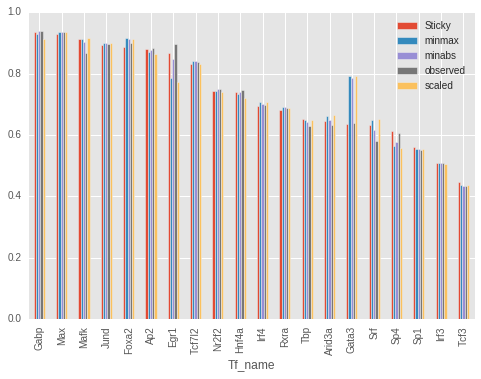

In [310]:
plot_df = pd.DataFrame(columns=["Tf_name", "Sticky", "minmax","minabs", "observed","scaled"])
for tf in combined_list:
    tfs = name2pbmchip[tf]
    #f1000 = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/Kibet-F1000Research/ChIP_seq/Results"
    #f1000 = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/ChIP-seq/Results"
    #test = pd.read_table("%s/%s/%s.energy" % (f1000, tfs,tfs), index_col="Motif")
    energy = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/%s/%s.max_kmer" % (tf.capitalize(), tf.lower())
    #new_test = test.append(pd.read_table(energy, index_col="Motif"))
    new_test = pd.read_table(energy, index_col="Motif")
    new_test.sort_values("AUC", ascending=False, inplace=True)
    # Use this to add each to a specific column fro plotting purpose
    #print tf
    sticky = new_test[new_test.index.str.contains("sticky")]["AUC"].mean()
    minmax = new_test[new_test.index.str.contains("minmax")]["AUC"].mean()
    minabs = new_test[new_test.index.str.contains("minabs")]["AUC"].mean()
    observed = new_test[new_test.index.str.contains("observed")]["AUC"].mean()
    scaled = new_test[new_test.index.str.contains("scaled")]["AUC"].mean()
    
    df2 = pd.DataFrame([[tf, sticky,minmax,minabs,observed,scaled]], columns=["Tf_name","Sticky", "minmax","minabs", "observed","scaled"])
    plot_df = plot_df.append(df2)
    
    #print new_test
plot_df.set_index("Tf_name", inplace=True)
plot_df.sort_values(by="Sticky", ascending=False, inplace=True)
plot_df.plot(kind="bar")

In [311]:
#max_kmer_pos
plot_df.mean()

Sticky      0.734125
minmax      0.738887
minabs      0.740363
observed    0.730662
scaled      0.735837
dtype: float64

In [206]:
#max_kmer_pos
plot_df.mean()

Sticky       0.720037
minmax       0.710287
minabs       0.703275
observed     0.686837
corrected    0.707300
dtype: float64

In [211]:
#max_kmer
plot_df.mean()

Sticky       0.740850
minmax       0.738887
minabs       0.740363
observed     0.737637
corrected    0.744375
dtype: float64

In [216]:
#energymer
plot_df.mean()

Sticky       0.651787
minmax       0.621450
minabs       0.605775
observed     0.589325
corrected    0.613400
dtype: float64

In [214]:
#energy
plot_df.mean()

Sticky       0.690088
minmax       0.671538
minabs       0.696975
observed     0.663600
corrected    0.692225
dtype: float64

In [ ]:
plot_df = pd.DataFrame(columns=["Tf_name", "Sticky", "minmax","minabs", "observed"])
for tf in tf_list:
    tfs = name2pbmchip[tf]
    #f1000 = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/Kibet-F1000Research/ChIP_seq/Results"
    #f1000 = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/ChIP-seq/Results"
    #test = pd.read_table("%s/%s/%s.energy" % (f1000, tfs,tfs), index_col="Motif")
    energy = "/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/%s/%s.energy" % (tf.capitalize(), tf.lower())
    #new_test = test.append(pd.read_table(energy, index_col="Motif"))
    new_test = pd.read_table(energy, index_col="Motif")
    new_test.sort_values("AUC", ascending=False, inplace=True)
    
    sticky = new_test[new_test.index.str.contains("sticky")]["AUC"].mean()
    minmax = new_test[new_test.index.str.contains("minmax")]["AUC"].mean()
    minabs = new_test[new_test.index.str.contains("minabs")]["AUC"].mean()
    observed = new_test[new_test.index.str.contains("observed")]["AUC"].mean()
    
    df2 = pd.DataFrame([[tf, sticky,minmax,minabs, observed]], columns=["Tf_name","Sticky", "minmax", "minabs", "observed"])
    plot_df = plot_df.append(df2)   
    #print new_test
    
plot_df.set_index("Tf_name", inplace=True) 
plot_df.sort_values(by="Sticky", ascending=False, inplace=True)
plot_df.plot(kind="bar")

In [ ]:
plot_df.plot(kind="bar")
plt.savefig("/home/kipkurui/Dropbox/PHD/Documents/Phd_Thesis/Chapter5/Figs/sticky_minmax_obs.pdf", bbox_inches='tight')

In [ ]:
plot_df.plot(kind="bar")

The next stage now is to get the the whole pipeline, all the way to assessment and visualization in place in such a way that I can compare all of them as fast as possible:The next steps of action, therefore, are to:
1. Make the assessment and plotting of ranks a one stroke task
2. Ensure the training stage can be carried out in one go as well, limit any repetition of steps
3. Test a number of motifs and see how they perform compared with the motifs before the re-ranking as well as those in the database using PBM and ChIP-seq data
4. Wrap everything into a straight forward analystics

In [ ]:
cd /home/kipkurui/Project/MARS/

In [ ]:
#test = pd.read_table("/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/Max/Max_3863.1_8mers_combined.txt", index_col="8-mer", usecols=["8-mer", "E-score"])

## A k-mer scoring algorithm

### Test the quality of the generated motifs in a single file

### Scale the data

At this point I need to use the Scikit-learn module to scale the data to 0 and 1, in a way that will allow me to use them at ease in my transformations

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler((0.001,1))
X_train_minmax = min_max_scaler.fit_transform(dn_hg[1])

In [ ]:
scalled_data = pd.DataFrame(dn_hg[0])
scalled_data = scalled_data.T.append(pd.Series(X_train_minmax), ignore_index=True).T

In [ ]:
scalled_data.to_csv("dn_hg_scalled.txt", sep="\t", index=None, index_label=None, header=None)

In [ ]:
import numpy as np
from sklearn.preprocessing import scale
scale(dn_hg[1])
dn_hg = pd.read_table("/home/kipkurui/Project/PBM_DNase/Data/Dn-Hg/DN-Hgcomb.txt", header=None)

### Loop through the various TFs and get the analysis going

I should connect this with the motif generation, conversion and assessment in one go. After this, I need to see how well this is working in other TFs, especially those that may be negatively affected by the background correction. I should identify the TFs that are well know to be affected by the sticky kmers. 

In [ ]:
for tf in "Egr1  Esrra  Gata3  Hnf4a  Mafk  Max  Myb  Tcf3".split():
    combine_meme(tf)
    run_assess(tf)

In [326]:
names = pd.read_table("/home/kipkurui/Project/PBM_DNase/Data/DN_Hg_max_normalized_diff_scalled.txt", header=None)

In [ ]:
#scores = pd.read_table("/home/kipkurui/Project/PBM_DNase/Data/Dn_hg_max_normalized_diff.txt", header=None)

## Re-create the noise

In this section, we recreate how we had previously generated the background noise.

In [3]:
import pandas as pd

In [4]:
hg = pd.read_table("/home/kipkurui/Project/Data/hg19-kmercounts.txt", header=None)
hg_gapless = hg[hg[0].apply(lambda x: len(x) ==8)]
hg_gapless = hg_gapless.sort_values(by=0)
hg_gapless.reset_index(drop=True, inplace=True)

hg_gapless.set_index(0, inplace=True)
hg_gapless.index.name = "k-mers"
hg_gapless.columns = ["counts"]

hg_gapless.to_csv("/home/kipkurui/Project/Data/Clean/hg19_8mer_counts.txt", sep="\t")

In [5]:
dn = pd.read_table("/home/kipkurui/Project/Data/Dnase-kmercounts-complete.txt", header=None)
dn_gapless = dn[dn[0].apply(lambda x: len(x) ==8)]
dn_gapless = dn_gapless.sort_values(by=0)
dn_gapless.reset_index(drop=True, inplace=True)

dn_gapless.set_index(0, inplace=True)
dn_gapless.index.name = "k-mers"
dn_gapless.columns = ["counts"]

dn_gapless.to_csv("/home/kipkurui/Project/Data/Clean/Dnase_cluster_v2_8mer_counts.txt", sep="\t")

In [6]:
hg_dn = dn_gapless.copy()
dn_hg = dn_gapless.copy()

hg_dn["counts"] = (hg_gapless["counts"]/sum(hg_gapless["counts"])) - (dn_gapless["counts"]/sum(dn_gapless["counts"]))
dn_hg["counts"] = (dn_gapless["counts"]/sum(dn_gapless["counts"])) - (hg_gapless["counts"]/sum(hg_gapless["counts"]))

In [7]:
sticky_kmer = """CCCCGCCC
AAAAAAAA
GAAAAAAA
GGAAAAAA
CGAAAAAA
ATTATTTA
ATATTAAA
AGAACAAA
TTAATAAA
AACAAAAA
AATTAATA
ATAAATTA
GGAGATAA
ATAAAAAG
GGTAACAA
GAGATAAA
AATAAATA
AAATGATA
ATTTGTTC
AAGAACAA
ATAAACGA
ACAAAGAA
AAAACAAA
GGGGGAGA
GGGGGAAA
GTGGGGAA
AACAATAT
TTGATAAA
CATAACAA
AATATTAA
CCGCCCCA
GGTGGGGA
CCATAACA
AACCAAAA
AATTATCA
GGCGGGGA
TTATAAAA
ATTAGATG
ATAAGAAA
ATTAAAAA
TAACAAAA
CCCTCCCC
ATTTTACC
TTAAAAAA
AACTAATA
AACAAGAA
AGTAGGGG
ATAATAAA
TATAAAAA
AGTTTTAT""".split()

In [8]:
pd.DataFrame(dn_hg["counts"]/dn_hg["counts"].max()).to_csv("/home/kipkurui/Project/PBM_DNase/Data/Dn-Hg/Dn_hg_max_normalized.txt", header=False, sep="\t")

### Plot the noise difference

In [9]:
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.style.use('ggplot')

In [10]:
sticky = hg_dn.ix[sticky_kmer]
sticky = sticky/sticky["counts"].max()

sticky.plot(kind='bar', title="Normalized k-mer count difference between Hg19 and Clustered DNase")
plt.axhline(0, color='k')
plt.savefig("/home/kipkurui/Dropbox/PHD/Documents/Phd_Thesis/Chapter5/Figs/sticky_kmer_bar.pdf", bbox_inches='tight')

In [12]:
sticky.to_clipboard()

In [240]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler((float(tau.min()),float(tau.max())))
X_train_minmax = min_max_scaler.fit_transform(hg_dn["counts"])

/home/kipkurui/anaconda2/envs/dream_challenge/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/kipkurui/anaconda2/envs/dream_challenge/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [233]:
tau_file = "/home/kipkurui/Project/Others_work/Bayesian_PBM_Analysis/Bayesian_PBM_Analysis/background_example/estimated_noise.txt"
tau = pd.read_table(tau_file, header=None)

In [243]:
from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler(with_mean=False)
X_train_minmax = min_max_scaler.fit_transform(hg_dn["counts"])

/home/kipkurui/anaconda2/envs/dream_challenge/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/kipkurui/anaconda2/envs/dream_challenge/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [235]:
pd.Series(X_train_minmax).to_csv("/home/kipkurui/Project/Data/Clean/hg_dn_backround_noise2.txt", index=False)

In [244]:
test = pd.Series(X_train_minmax)

In [ ]:
test = hg_dn["counts"]/hg_dn["counts"].max()

In [ ]:
sum((test+0.6) < 0)

In [ ]:
#hg_dn.sort_values(by="counts", ascending=False).head(100)

In [ ]:
#dn_hg.sort_values(by="counts", ascending=False).head(100)

In [335]:
test = pd.read_table("/home/kipkurui/Project/PBM_DNase/Results/PBM_Reranked/Mafk/Mafk_3106_contig8mers.observed")

In [358]:
#scores = pd.read_table("/home/kipkurui/Project/Data/Clean/hg_dn_backround_noise3.txt", header=None)
scores = pd.read_table("/home/kipkurui/Project/PBM_DNase/Data/Dn_hg_max_normalized_diff.txt", header=None)

In [359]:
test["E-score"] = scores

In [361]:
test["E-score"] = ((test["E-score"]/test["E-score"].max()) + ((test["E-score"]/test["E-score"].max()).min() * -1))

In [364]:
test["E-score"].min()

0.0

In [365]:
test.to_csv("/home/kipkurui/Project/Data/Clean/dn_hg_backround_noise_mean_std_maxnormalized_positive.txt", index=False, sep="\t")